# 04 — TD($\lambda$): most między TD(0) i Monte Carlo

W TD(0) uczymy się na podstawie **jednego kroku** (bootstrapping), a w MC uczymy się z **pełnego zwrotu** $G_t$ po zakończeniu epizodu.

TD($\lambda$) jest „mostem” pomiędzy tymi podejściami:
- dla $\lambda=0$ dostajemy **TD(0)**,
- dla $\lambda \to 1$ (w epizodycznych zadaniach) zbliżamy się do **MC**,
- wartości pośrednie $\lambda\in(0,1)$ mieszają informację z różnych horyzontów.


## Co robimy w tym notebooku?

1) Implementujemy i uruchamiamy **TD($\lambda$) prediction** dla $V^\pi(s)$ (dla ustalonej polityki, zwykle losowej).
2) Porównujemy wyniki dla różnych $\lambda$ (oraz porównawczo: TD(0) i MC).
3) Patrzymy na metryki typu MSE do DP (jeśli dostępne) i na intuicyjne wizualizacje (heatmapy).

**Ważne:** To nadal jest *prediction* (policy evaluation), czyli nie uczymy tu polityki — uczymy tylko $V^\pi$.


## Skąd bierze się idea TD($\lambda$)?

### 1) $n$-step return (uogólnienie TD(0))
Możemy zdefiniować zwrot „na $n$ kroków”:

$$
G_{t:t+n} = R_{t+1} + \gamma R_{t+2} + \dots + \gamma^{n-1} R_{t+n} + \gamma^n V(S_{t+n}).
$$

- dla $n=1$ dostajemy target TD(0): $R_{t+1}+\gamma V(S_{t+1})$,
- dla dużego $n$ (aż do końca epizodu) zbliżamy się do MC.

### 2) $\lambda$-return (mieszanie horyzontów)
TD($\lambda$) miesza te zwroty:

$$
G_t^\lambda = (1-\lambda)\sum_{n=1}^{\infty}\lambda^{n-1}G_{t:t+n}.
$$

To jest tzw. **forward view**: można myśleć o TD($\lambda$) jako o ważonej średniej zwrotów $n$-krokowych.


## Implementacja w praktyce: eligibility traces (backward view)

W praktyce nie liczymy explicite całej sumy po $n$.
Zamiast tego używamy **eligibility traces** $e(s)$, które mówią „jak bardzo stan $s$ jest jeszcze kredytowany za bieżący błąd TD”.

Wersja tablicowa (accumulating trace):
1) liczymy błąd TD jak w TD(0):
$$
\delta_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t),
$$
2) aktualizujemy ślady:
$$
e(s)\leftarrow \gamma\lambda\, e(s),\qquad e(S_t)\leftarrow e(S_t)+1,
$$
3) robimy update na wszystkich stanach proporcjonalnie do $e$:
$$
V(s)\leftarrow V(s)+\alpha\,\delta_t\, e(s).
$$

**Intuicja:** pojedynczy błąd $\delta_t$ jest “rozlewany wstecz” na wcześniejsze stany z epizodu, malejąc geometrycznie z $\gamma\lambda$.


In [27]:
import os, sys
# dodaj katalog główny repo do ścieżki importów
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

import numpy as np
import matplotlib.pyplot as plt

In [28]:
from envs.wrappers import make_gridworld, get_spec
from envs.frozenlake import FROZENLAKE_MAPS, build_frozenlake_P, find_start_state, PModelEnv

from algorithms.td_lambda import td_lambda_prediction
from algorithms.td import td0_prediction
from algorithms.mc import mc_prediction
from algorithms.dp import policy_evaluation
from algorithms.utils import plot_value_heatmap, plot_learning_curve

## Wybór środowiska

In [13]:
ENV_KIND = "frozenlake"   # "gridworld" albo "frozenlake"
SLIPPERY = True

if ENV_KIND == "gridworld":
    env = make_gridworld(seed=0)

elif ENV_KIND == "frozenlake":
    desc = FROZENLAKE_MAPS["8x8"]
    P, nS, nA, nrow, ncol, desc_arr = build_frozenlake_P(desc, is_slippery=SLIPPERY)
    s0 = find_start_state(desc_arr)
    env = PModelEnv(P, start_state=s0, seed=0, desc=desc_arr)
    env.nrow, env.ncol, env.desc = nrow, ncol, desc_arr
else:
    raise ValueError("Nieznane ENV_KIND")

spec = get_spec(env, gamma=0.99)
if spec.desc is not None:
    print("FrozenLake map:")
    print("\n".join("".join(row) for row in spec.desc))
spec

FrozenLake map:
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


DiscreteEnvSpec(nS=64, nA=4, shape=(8, 8), terminals={35, 41, 42, 46, 49, 19, 52, 54, 59, 29, 63}, gamma=0.99, desc=array([['S', 'F', 'F', 'F', 'F', 'F', 'F', 'F'],
       ['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F'],
       ['F', 'F', 'F', 'H', 'F', 'F', 'F', 'F'],
       ['F', 'F', 'F', 'F', 'F', 'H', 'F', 'F'],
       ['F', 'F', 'F', 'H', 'F', 'F', 'F', 'F'],
       ['F', 'H', 'H', 'F', 'F', 'F', 'H', 'F'],
       ['F', 'H', 'F', 'F', 'H', 'F', 'H', 'F'],
       ['F', 'F', 'F', 'H', 'F', 'F', 'F', 'G']], dtype='<U1'))

## 1) Polityka: losowa (żeby porównywać prediction)

### Polityka losowa i DP baseline

Definiujemy politykę losową:
$
\pi(a\mid s)=\frac{1}{|\mathcal{A}|}
$
czyli w każdym stanie wybieramy akcję równomiernie.

Jeśli środowisko udostępnia model `P`, liczymy DP baseline `V_dp` dla tej samej polityki.
To jest “prawda odniesienia” do liczenia MSE (gdy mamy model).


In [14]:
rng = np.random.default_rng(0)

# TODO (student): polityka losowa π
def random_policy(s):
    return int(rng.integers(0, spec.nA))  # rozwiązanie

# DP baseline (żeby zobaczyć, do czego zbliża się TD(λ))
V_dp = None
if hasattr(env, "P"):
    P_model = env.P
    pi_random = np.ones((spec.nS, spec.nA), dtype=np.float64) / spec.nA
    V_dp = policy_evaluation(P_model, pi_random, gamma=spec.gamma)

## 2) Diagnostyka: success rate i coverage (FrozenLake ma bardzo rzadką nagrodę)

Jeśli polityka losowa prawie nigdy nie dociera do mety, to wszystkie metody (MC/TD/TD(λ)) będą długo wyglądały podobnie (prawie wszędzie ~0).

Poniżej mierzymy **success_rate** i pokazujemy **coverage** stanów.

### 2.1) Diagnostyka: czy w ogóle jest sygnał do nauki?

FrozenLake ma rzadką nagrodę, więc zanim interpretujemy heatmapy:
- liczymy `success_rate` (odsetek epizodów z nagrodą),
- liczymy `coverage` (ile razy odwiedzamy stany).

Jeśli `success_rate≈0` i coverage jest słabe, to wartości mogą długo wyglądać “płasko” (blisko zera),
nawet jeśli algorytm jest poprawny.


Random policy: success_rate=0.001, avg_return=0.0010


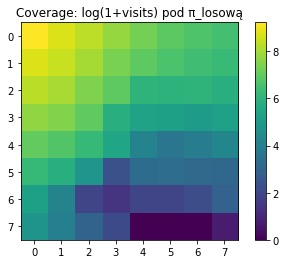

In [26]:
def evaluate_policy_success(env, policy, episodes=2_000, max_steps=10_000):
    successes = 0
    total_returns = []
    for _ in range(episodes):
        s, _ = env.reset()
        G = 0.0
        for _ in range(max_steps):
            a = int(policy(int(s)))
            s, r, terminated, truncated, _ = env.step(a)
            G += float(r)
            if terminated or truncated:
                break
        total_returns.append(G)
        if G > 0.0:
            successes += 1
    return successes / episodes, float(np.mean(total_returns))

def state_visit_counts(env, policy, nS, episodes=2_000, max_steps=10_000):
    counts = np.zeros(nS, dtype=np.int64)
    for _ in range(episodes):
        s, _ = env.reset()
        counts[int(s)] += 1
        for _ in range(max_steps):
            a = int(policy(int(s)))
            s, r, terminated, truncated, _ = env.step(a)
            counts[int(s)] += 1
            if terminated or truncated:
                break
    return counts

sr, avg_ret = evaluate_policy_success(env, random_policy, episodes=2_000)
print(f"Random policy: success_rate={sr:.3f}, avg_return={avg_ret:.4f}")

counts = state_visit_counts(env, random_policy, nS=spec.nS, episodes=2_000)
plot_value_heatmap(np.log1p(counts).astype(np.float64), spec.shape, title="Coverage: log(1+visits) pod π_losową")


## 3) Porównanie map V(s) dla różnych λ

### 3.1) Porównanie map wartości: TD(0), MC i TD(λ)

Uruchamiamy kilka metod na tym samym budżecie epizodów:
- TD(0) (λ=0) — 1‑krokowy bootstrap,
- MC — pełny zwrot z epizodu,
- TD(λ) dla kilku wartości λ.

Heatmapy pokazują, w których stanach polityka ma większą szansę “doprowadzić” do nagrody.
Dla większego λ sygnał może propagować szybciej wstecz (ale zależy od α i od tego, czy są sukcesy).


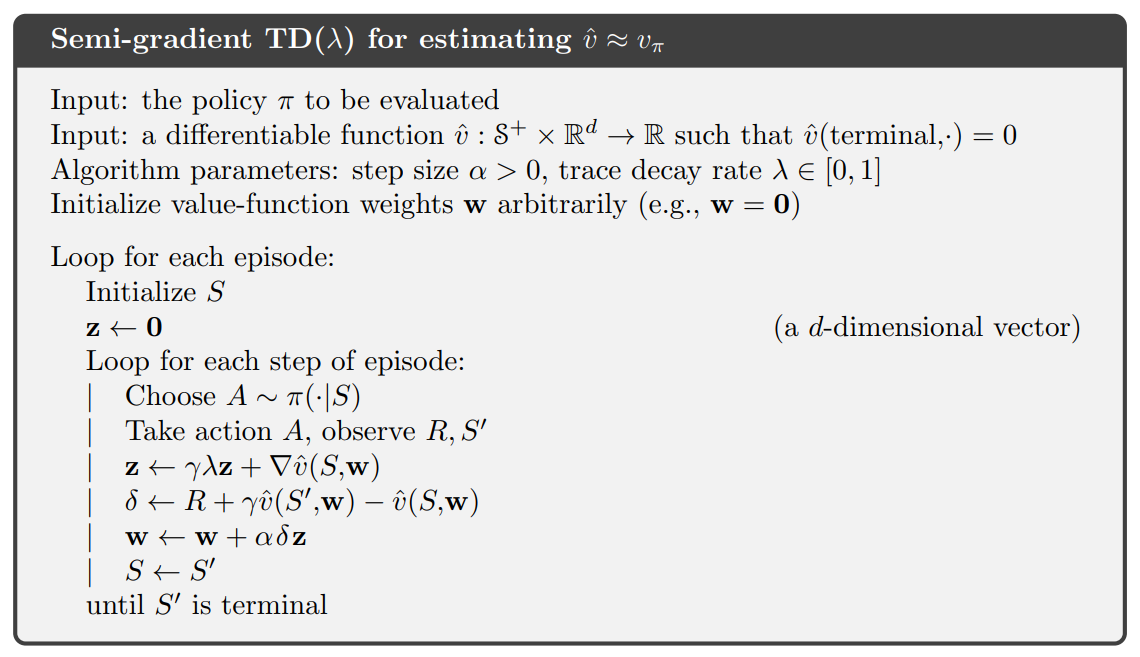

### Tabular TD($\lambda$) (prediction) — eligibility traces (backward view)

**Cel:** estymujemy $V^\pi(s)$ dla ustalonej polityki $\pi$.

**Parametry:** krok uczenia $\alpha>0$, discount $\gamma\in[0,1)$, trace-decay $\lambda\in[0,1]$.

**Inicjalizacja:** $V(s)$ dowolnie (zwykle 0), $V(\text{terminal})=0$.

Dla każdego epizodu:
1. Ustaw ślady: $e(s)\leftarrow 0$ dla wszystkich stanów $s$.
2. Zresetuj środowisko: $S \leftarrow \text{reset}()$.
3. Dopóki $S$ nie jest terminalny:
   - Wybierz akcję: $A \sim \pi(\cdot|S)$
   - Wykonaj krok: obserwuj $R, S', done$
   - Ustal bootstrap:
     - jeśli `done=True`, przyjmij $V(S')=0$
   - Oblicz błąd TD:
     $$
     \delta \leftarrow R + \gamma V(S') - V(S)
     $$
   - Zaktualizuj ślady (wariant **accumulating**):
     $$
     e \leftarrow \gamma\lambda\, e,\qquad e(S) \leftarrow e(S) + 1
     $$
     (wariant **replacing**: zamiast $e(S)\leftarrow e(S)+1$ daj $e(S)\leftarrow 1$)
   - Zaktualizuj wszystkie stany proporcjonalnie do śladu:
     $$
     V \leftarrow V + \alpha\,\delta\, e
     $$
   - Przejdź dalej: $S \leftarrow S'$

**Intuicja:** im większe $\lambda$, tym wolniej zanikają ślady i tym dalej “wstecz” rozchodzi się poprawka.


### TD(λ): notacja z Suttona vs nasza implementacja (tabular)

W książce (Sutton & Barto) TD(λ) jest zapisane w wersji **semi-gradient**:
- parametry wartości: $w$,
- ślad (eligibility trace): $z$,
- gradient wartości: $\nabla_w \hat v(S_t; w)$.

My w FrozenLake robimy przypadek **tablicowy (tabular)**, gdzie:
- parametry $w$ to po prostu tablica $V$ (jedna liczba na stan),
- $\nabla_w \hat v(S_t; w)$ jest wektorem one-hot (1 w aktualnym stanie, 0 gdzie indziej),
- dlatego ślad \(z\) jest równoważny tablicy śladów po stanach \(e\).

| Sutton (semi-gradient) | U nas (tabular) |
|---|---|
| $w$ | $V$ |
| $z$ | $e$ |
| $z \leftarrow \gamma\lambda z + \nabla \hat v(S,w)$ | $e \leftarrow \gamma\lambda e;\; e[S]\leftarrow e[S]+1$ |
| $\delta = R + \gamma \hat v(S',w) - \hat v(S,w)$ | $\delta = r + \gamma V(S') - V(S)$ (a dla terminal: $V(S')=0$) |
| $w \leftarrow w + \alpha \delta z$ | $V \leftarrow V + \alpha \delta e$ |

Wniosek: to **ten sam algorytm**, tylko zapisany w notacji dopasowanej do tablic.


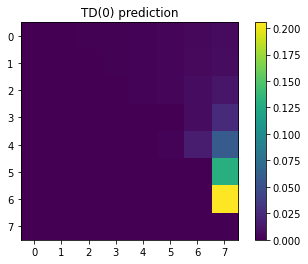

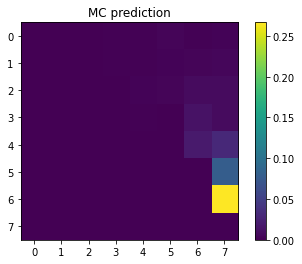

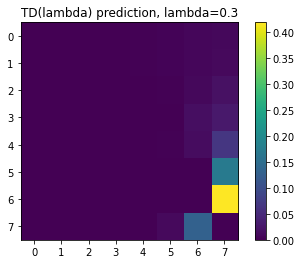

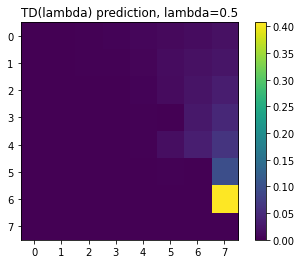

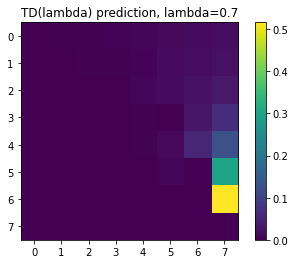

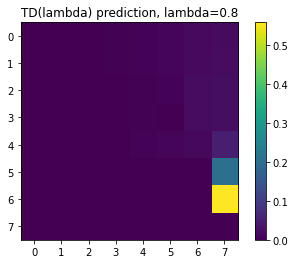

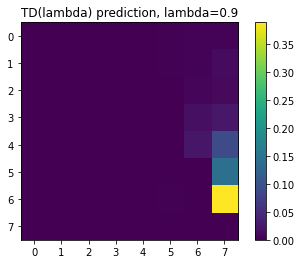

In [21]:
EP = 5_000
ALPHA = 0.1

# Punkty odniesienia:
V_td0 = td0_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=ALPHA, episodes=EP)
V_mc, _ = mc_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, episodes=EP)

plot_value_heatmap(V_td0, spec.shape, title="TD(0) prediction")
plot_value_heatmap(V_mc, spec.shape, title="MC prediction")

for lam in [0.3,0.5, 0.7, 0.8,0.9]:
    V_lam = td_lambda_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=ALPHA, lam=lam, episodes=EP)
    plot_value_heatmap(V_lam, spec.shape, title=f"TD(lambda) prediction, lambda={lam}")

## 4) Wczesny reżim: TD(λ) potrafi szybciej „rozlać” sygnał wstecz

Najłatwiej zobaczyć różnicę, gdy:
- patrzymy na małe budżety epizodów,
- mamy przynajmniej trochę sukcesów,
- oraz dobieramy α sensownie do λ.

Poniżej porównanie dla kilku małych `E` i dwóch wartości λ.

### 4.1) Wczesny reżim (mało epizodów): gdzie widać różnice najszybciej

Dla małych budżetów epizodów (np. 100–1000) łatwiej zobaczyć różnice w dynamice uczenia.

Dla dużego λ update rozlewa się przez eligibility traces na wiele stanów,
więc stosujemy prostą heurystykę stabilizacji:
\[
\alpha_{\text{eff}}=\alpha(1-\lambda)
\]
żeby update nie był zbyt agresywny.



=== E = 100 ===


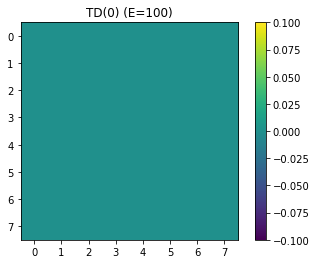

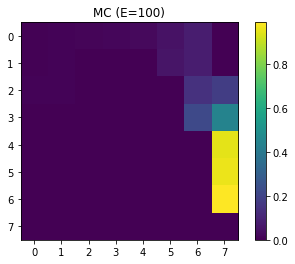

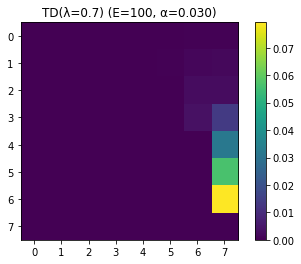

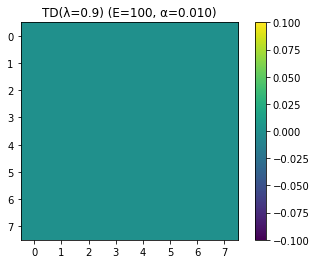


=== E = 200 ===


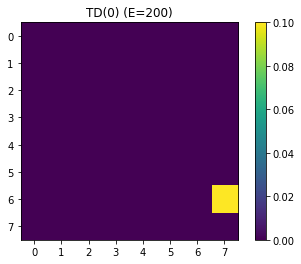

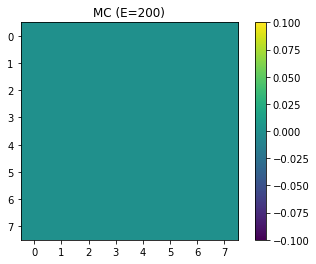

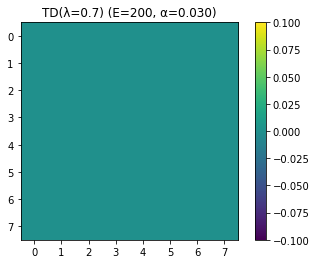

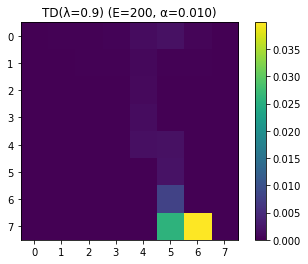


=== E = 500 ===


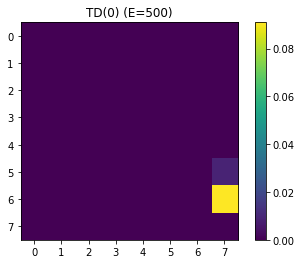

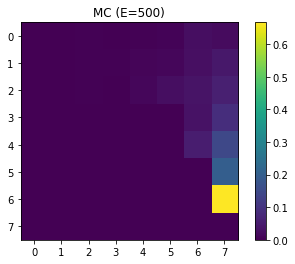

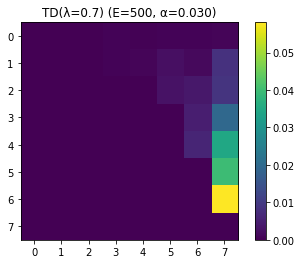

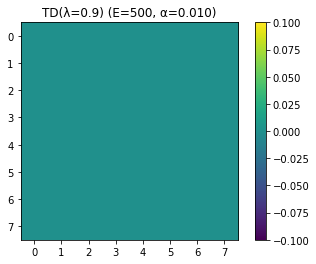


=== E = 1000 ===


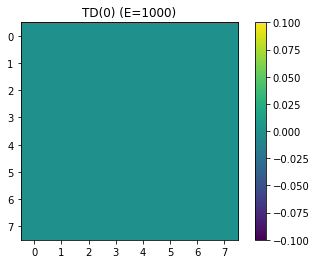

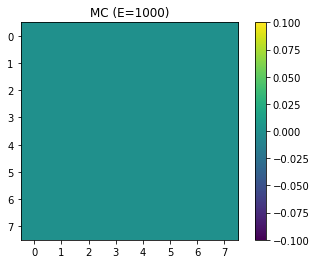

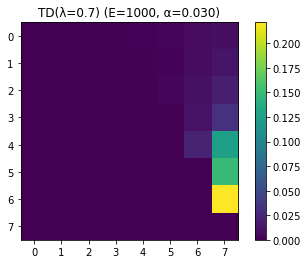

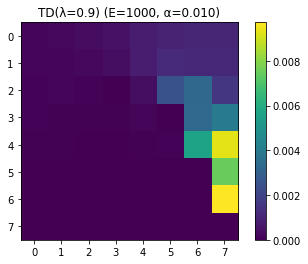

In [25]:
SMALL_EPS = [100, 200, 500, 1_000]
ALPHA_SMALL = 0.1
LAMS_TO_SHOW = [0.0, 0.7, 0.9]

for E in SMALL_EPS:
    print("\n=== E =", E, "===")
    V_td0_E = td0_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=ALPHA_SMALL, episodes=E)
    V_mc_E, _ = mc_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, episodes=E)

    plot_value_heatmap(V_td0_E, spec.shape, title=f"TD(0) (E={E})")
    plot_value_heatmap(V_mc_E, spec.shape, title=f"MC (E={E})")

    for lam in [0.7, 0.9]:
        # prosta heurystyka: dla większego λ zmniejszamy α, żeby update nie był zbyt agresywny
        alpha_eff = ALPHA_SMALL * (1.0 - lam)
        V_lam_E = td_lambda_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=alpha_eff, lam=lam, episodes=E)
        plot_value_heatmap(V_lam_E, spec.shape, title=f"TD(λ={lam}) (E={E}, α={alpha_eff:.3f})")


## 5) Krzywe MSE vs λ (jeśli mamy DP baseline)

### 5.1 Metryka: MSE do DP baseline w funkcji λ (jeśli mamy model)

Jeśli mamy `V_dp`, liczymy:
\[
\text{MSE}=\frac{1}{|S|}\sum_s\big(V(s)-V_{dp}(s)\big)^2.
\]

To pozwala liczbowo porównać, jak blisko “prawdy” jesteśmy dla różnych λ.
Dla czytelności traktujemy:
- λ=0 jako TD(0),
- λ=1 jako punkt odniesienia z MC (koniec mostu TD ↔ MC).


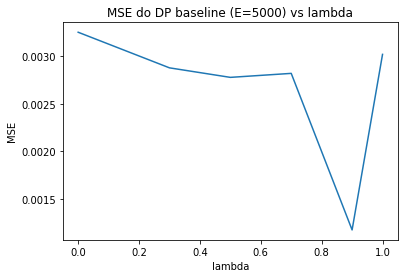

In [22]:
if V_dp is None:
    print("Brak DP baseline → porównuj jakościowo mapy i stabilność.")
else:
    LAMS = [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]
    mses = []
    for lam in LAMS:
        if lam == 0.0:
            V = td0_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=ALPHA, episodes=EP)
        elif lam == 1.0:
            V, _ = mc_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, episodes=EP)
        else:
            V = td_lambda_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=ALPHA, lam=lam, episodes=EP)
        mses.append(float(np.mean((V - V_dp)**2)))

    plot_learning_curve(LAMS, mses, title=f"MSE do DP baseline (E={EP}) vs lambda", xlabel="lambda", ylabel="MSE")

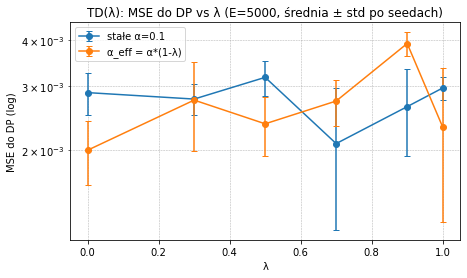

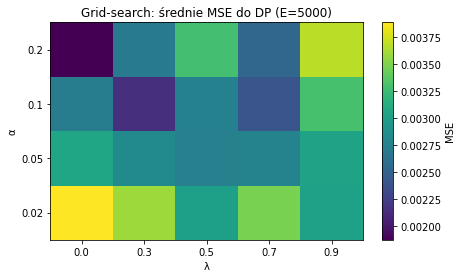

In [24]:
# Analiza: MSE do DP w funkcji λ (oraz prosta heurystyka doboru α).
# W FrozenLake (rzadka nagroda) efekt TD(λ) bywa subtelny, więc:
# - uśredniamy po kilku seedach,
# - oraz pokazujemy, że dobór α ma znaczenie.

if V_dp is None:
    print("Brak DP baseline → porównuj jakościowo mapy, success_rate i stabilność.")
else:
    LAMS = [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]   # 1.0 traktujemy jako MC (forward-view graniczny)
    ALPHA_BASE = 0.1
    SEEDS = [0, 1, 2, 3, 4]

    def make_env(seed: int):
        # multi-seed wspieramy sensownie dla FrozenLake (PModelEnv z seedem)
        if ENV_KIND == "frozenlake":
            env_i = PModelEnv(P, start_state=s0, seed=seed, desc=desc_arr)
            env_i.nrow, env_i.ncol, env_i.desc = nrow, ncol, desc_arr
            return env_i
        else:
            # fallback: ten sam env (gridworld)
            return env

    def run_value_estimate(env_i, lam: float, alpha: float, episodes: int):
        if lam == 1.0:
            V, _ = mc_prediction(env_i, random_policy, nS=spec.nS, gamma=spec.gamma, episodes=episodes)
            return V
        if lam == 0.0:
            return td0_prediction(env_i, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=alpha, episodes=episodes)
        return td_lambda_prediction(env_i, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=alpha, lam=lam, episodes=episodes)

    def mse_to_dp(V):
        return float(np.mean((V - V_dp) ** 2))

    # (1) MSE vs λ przy stałym α
    mses_fixed = []
    for lam in LAMS:
        lam_mses = []
        for seed in SEEDS:
            env_i = make_env(seed)
            V = run_value_estimate(env_i, lam=lam, alpha=ALPHA_BASE, episodes=EP)
            lam_mses.append(mse_to_dp(V))
        mses_fixed.append((np.mean(lam_mses), np.std(lam_mses)))

    # (2) MSE vs λ przy prostej heurystyce α_eff = α_base*(1-λ)
    # (intuicja: im większy λ, tym update "rozlewa się" przez trace → zmniejszamy krok)
    mses_scaled = []
    for lam in LAMS:
        lam_mses = []
        for seed in SEEDS:
            env_i = make_env(seed)
            if lam == 1.0:
                alpha_eff = None
            else:
                alpha_eff = ALPHA_BASE * (1.0 - lam)
            V = run_value_estimate(env_i, lam=lam, alpha=(ALPHA_BASE if alpha_eff is None else alpha_eff), episodes=EP)
            lam_mses.append(mse_to_dp(V))
        mses_scaled.append((np.mean(lam_mses), np.std(lam_mses)))

    # wykres: dwie krzywe
    x = np.array(LAMS, dtype=np.float64)
    y1 = np.array([m for m, s in mses_fixed], dtype=np.float64)
    e1 = np.array([s for m, s in mses_fixed], dtype=np.float64)
    y2 = np.array([m for m, s in mses_scaled], dtype=np.float64)
    e2 = np.array([s for m, s in mses_scaled], dtype=np.float64)

    plt.figure(figsize=(7, 4))
    plt.errorbar(x, y1, yerr=e1, marker="o", capsize=3, label=f"stałe α={ALPHA_BASE}")
    plt.errorbar(x, y2, yerr=e2, marker="o", capsize=3, label="α_eff = α*(1-λ)")
    plt.yscale("log")
    plt.xlabel("λ")
    plt.ylabel("MSE do DP (log)")
    plt.title(f"TD(λ): MSE do DP vs λ (E={EP}, średnia ± std po seedach)")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

    # (3) Mini grid-search: λ × α → mapa MSE (dla TD(λ), bez MC)
    LAMS_GRID = [0.0, 0.3, 0.5, 0.7, 0.9]
    ALPHAS_GRID = [0.02, 0.05, 0.1, 0.2]

    grid = np.zeros((len(ALPHAS_GRID), len(LAMS_GRID)), dtype=np.float64)

    for i_a, alpha in enumerate(ALPHAS_GRID):
        for i_l, lam in enumerate(LAMS_GRID):
            mses = []
            for seed in SEEDS:
                env_i = make_env(seed)
                V = run_value_estimate(env_i, lam=lam, alpha=alpha, episodes=EP)
                mses.append(mse_to_dp(V))
            grid[i_a, i_l] = float(np.mean(mses))

    plt.figure(figsize=(7, 4))
    plt.imshow(grid, aspect="auto", origin="lower")
    plt.xticks(np.arange(len(LAMS_GRID)), [str(l) for l in LAMS_GRID])
    plt.yticks(np.arange(len(ALPHAS_GRID)), [str(a) for a in ALPHAS_GRID])
    plt.xlabel("λ")
    plt.ylabel("α")
    plt.title(f"Grid-search: średnie MSE do DP (E={EP})")
    plt.colorbar(label="MSE")
    plt.show()


## 6) Co naprawdę robi λ w TD(λ)? Dwa spojrzenia: forward-view i backward-view

Parametr **λ ∈ [0,1]** kontroluje *jak daleko w czasie* rozlewamy błąd TD.

W praktyce spotkasz dwie równoważne intuicje:

---

### 6.1) Forward view (λ-return): „mieszanka wielu horyzontów”

Najpierw definiujemy **n-step return** (uogólnienie TD(0)):

$
G_t^{(n)} = r_{t+1} + \gamma r_{t+2} + \dots + \gamma^{n-1} r_{t+n} + \gamma^n V(S_{t+n}).
$

- dla **n=1** dostajesz TD(0) target: \(r_{t+1} + \gamma V(S_{t+1})\),
- dla **n = (koniec epizodu)** dostajesz Monte Carlo return \(G_t\).

Potem **λ-return** to ważona suma n-step returnów:

$
G_t^{\lambda} = (1-\lambda)\sum_{n=1}^{T-t-1} \lambda^{n-1} G_t^{(n)} + \lambda^{T-t-1} G_t,
$
gdzie $T$ to czas zakończenia epizodu.

**Intuicja:**
- **λ=0** → używasz tylko $n=1$ → **TD(0)**,
- **λ→1** → coraz większa waga długich horyzontów → **zbliżasz się do MC** (przy epizodach).

Wagi są geometryczne: $(1-\lambda)\lambda^{n-1}$.  
Średni „efektywny horyzont” (bardzo zgrubnie) to ok.:
$
\mathbb{E}[n] \approx \frac{1}{1-\lambda}.
$
Np. λ=0.9 → ~10 kroków, λ=0.99 → ~100 kroków (to intuicja).

---

### 6.2) Backward view (eligibility traces): „pamięć wstecz + rozlewanie błędu δ”

W implementacji nie liczymy całej sumy po n.
Zamiast tego utrzymujemy **eligibility trace** $e_t(s)$ dla każdego stanu:

$
e_t(s) \leftarrow \gamma\lambda\, e_{t-1}(s), \qquad
e_t(S_t) \leftarrow e_t(S_t) + 1
$
(to tzw. *accumulating traces*).

Następnie liczymy błąd TD (jak w TD(0)):

$
\delta_t = r_{t+1} + \gamma V(S_{t+1}) - V(S_t)
$
(z poprawką: jeśli terminal, to \(V(S_{t+1})=0\)),

i robimy update **na wszystkich stanach naraz**:

$
V(s) \leftarrow V(s) + \alpha\, \delta_t\, e_t(s).
$

**Kluczowe:**  
- przy **λ=0** mamy $e_t$ ≈ one-hot dla bieżącego stanu → aktualizujemy prawie tylko $S_t$ (jak TD(0)),  
- przy **większym λ** $e_t$ dłużej pamięta przeszłość → ten sam błąd $\delta_t$ aktualizuje też *wcześniejsze* stany.

W notacji Suttona dla wersji semi-gradient:
- trace nazywa się często **z**, u nas w tablicowej wersji to po prostu **e**.


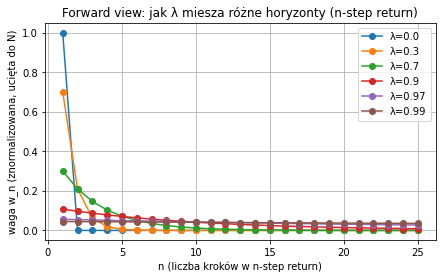

Przybliżony 'efektywny horyzont' E[n] ≈ 1/(1-λ):
  λ= 0.0: E[n]≈1.0
  λ= 0.3: E[n]≈1.4
  λ= 0.7: E[n]≈3.3
  λ= 0.9: E[n]≈10.0
  λ=0.97: E[n]≈33.3
  λ=0.99: E[n]≈100.0


In [29]:
import numpy as np
import matplotlib.pyplot as plt

def lambda_weights(lam: float, N: int = 25):
    """
    Wagi forward-view: (1-λ) λ^{n-1} dla n=1..N (ucięte do N i znormalizowane).
    Uwaga: w epizodach masa ogona i tak jest ucięta przez koniec epizodu.
    """
    n = np.arange(1, N+1)
    w = (1.0 - lam) * (lam ** (n-1))
    # normalizacja dla czytelności (bo ucinamy do N)
    w = w / w.sum()
    return n, w

LAMS = [0.0, 0.3, 0.7, 0.9, 0.97, 0.99]
N = 25

plt.figure(figsize=(7, 4))
for lam in LAMS:
    n, w = lambda_weights(lam, N=N)
    plt.plot(n, w, marker="o", label=f"λ={lam}")
plt.xlabel("n (liczba kroków w n-step return)")
plt.ylabel("waga w_n (znormalizowana, ucięta do N)")
plt.title("Forward view: jak λ miesza różne horyzonty (n-step return)")
plt.grid(True)
plt.legend()
plt.show()

print("Przybliżony 'efektywny horyzont' E[n] ≈ 1/(1-λ):")
for lam in LAMS:
    if lam < 1.0:
        print(f"  λ={lam:>4}: E[n]≈{1.0/(1.0-lam):.1f}")
    else:
        print("  λ=1.0: MC (horyzont = długość epizodu)")


#### λ nie wybiera jednego „n”, tylko robi geometrię: małe λ = krótkie horyzonty dominują, duże λ = długie horyzonty dominują.

Długość epizodu (kroki): 40, done=False, suma nagród=0.0
Pierwsze stany: [0, 1, 9, 10, 11, 12, 4, 4, 5, 13, 21, 20, 12, 4, 3] ...
Unikalne stany w tej trajektorii: [0, 1, 9, 10, 11, 12, 4, 5, 13, 21, 20, 3, 2, 22, 28] ...


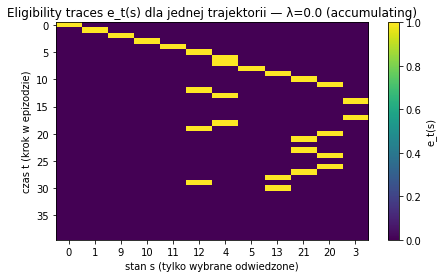

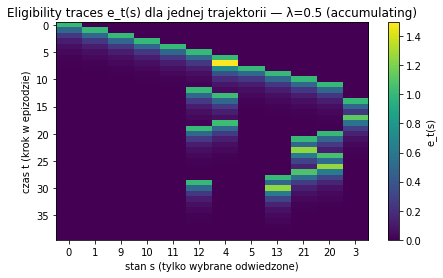

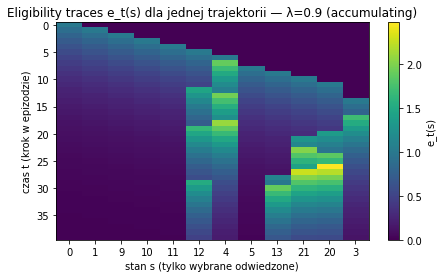


Demo update w kroku t=10: ΔV(s) = α·δ·e_t(s), przy α=0.1, δ=1.0
  λ=0.0: top stany aktualizowane wstecz:
    s=21   ΔV≈0.1000
  λ=0.9: top stany aktualizowane wstecz:
    s=4    ΔV≈0.1338
    s=21   ΔV≈0.1000
    s=13   ΔV≈0.0891
    s=5    ΔV≈0.0794
    s=12   ΔV≈0.0562
    s=11   ΔV≈0.0500
    s=10   ΔV≈0.0446
    s=9    ΔV≈0.0397
    s=1    ΔV≈0.0354
    s=0    ΔV≈0.0315


In [30]:
def rollout_episode(env, policy, max_steps=50):
    """Zbiera jedną trajektorię: stany, akcje, nagrody."""
    s, _ = env.reset()
    s = int(s)
    states = [s]
    actions, rewards = [], []
    done = False

    for _ in range(max_steps):
        a = int(policy(s))
        sp, r, terminated, truncated, _ = env.step(a)
        sp = int(sp)

        actions.append(a)
        rewards.append(float(r))
        states.append(sp)

        s = sp
        done = bool(terminated or truncated)
        if done:
            break
    return states, actions, rewards, done

def trace_matrix(states, nS, gamma, lam, mode="accumulating"):
    """
    Zwraca macierz E[t, s] = e_t(s) dla t=0..T-1 (tam gdzie była akcja).
    mode: 'accumulating' (e[s]+=1) lub 'replacing' (e[s]=1).
    """
    e = np.zeros(nS, dtype=np.float64)
    rows = []
    for s in states[:-1]:
        e *= gamma * lam
        if mode == "replacing":
            e[int(s)] = 1.0
        else:
            e[int(s)] += 1.0
        rows.append(e.copy())
    return np.vstack(rows)

# 1) Zbierzmy jedną trajektorię (krótką)
states, actions, rewards, done = rollout_episode(env, random_policy, max_steps=40)
unique_states = list(dict.fromkeys(states))  # unikalne stany w kolejności pojawienia się

print(f"Długość epizodu (kroki): {len(rewards)}, done={done}, suma nagród={sum(rewards):.1f}")
print("Pierwsze stany:", states[:15], "...")
print("Unikalne stany w tej trajektorii:", unique_states[:15], ("..." if len(unique_states) > 15 else ""))

# 2) Żeby wykres był czytelny, pokażemy tylko pierwsze K unikalnych stanów z epizodu
K = min(12, len(unique_states))
show_states = unique_states[:K]

# 3) Porównajmy ślady dla kilku λ (accumulating traces)
for lam in [0.0, 0.5, 0.9]:
    E = trace_matrix(states, nS=spec.nS, gamma=spec.gamma, lam=lam, mode="accumulating")
    E_sub = E[:, show_states]

    plt.figure(figsize=(1 + 0.5*K, 4))
    plt.imshow(E_sub, aspect="auto", origin="upper")
    plt.colorbar(label="e_t(s)")
    plt.xticks(np.arange(K), [str(s) for s in show_states], rotation=0)
    plt.xlabel("stan s (tylko wybrane odwiedzone)")
    plt.ylabel("czas t (krok w epizodzie)")
    plt.title(f"Eligibility traces e_t(s) dla jednej trajektorii — λ={lam} (accumulating)")
    plt.show()

# 4) Ten sam krok t0: zobaczmy, które stany dostają największy update α·δ·e_t(s)
t0 = min(10, len(rewards)-1) if len(rewards) > 0 else 0
delta_demo = 1.0
alpha_demo = 0.1

print(f"\nDemo update w kroku t={t0}: ΔV(s) = α·δ·e_t(s), przy α={alpha_demo}, δ={delta_demo}")
for lam in [0.0, 0.9]:
    E = trace_matrix(states, nS=spec.nS, gamma=spec.gamma, lam=lam, mode="accumulating")
    e_t = E[t0].copy()
    dV = alpha_demo * delta_demo * e_t

    idx = np.argsort(-dV)  # malejąco
    top = [(int(i), float(dV[i])) for i in idx[:10] if dV[i] > 1e-12]

    print(f"  λ={lam}: top stany aktualizowane wstecz:")
    for s, val in top:
        print(f"    s={s:<3}  ΔV≈{val:.4f}")


### Wnioski: 
- Przy λ=0 na heatmapie prawie zawsze świeci tylko „bieżący” stan → TD(0).

- Przy λ=0.9 ślad utrzymuje się i wiele wcześniejszych stanów ma niezerowe e(s).

- Dlatego jeden błąd δ aktualizuje nie tylko $S_t$, ale też „ciąg przyczynowy” wstecz.

**Bonus dydaktyczny**: przełącz mode="replacing" i sprwadź różnicę vs accumulating.

## (Opcjonalnie) Reward shaping: żeby TD(λ) miało “co rozlewać” wstecz

Jeśli nagroda jest ekstremalnie rzadka (FrozenLake 0/1), to nawet TD(λ) może wyglądać podobnie do TD(0) — bo **δ ≈ 0** w większości kroków.

Jednym ze sposobów dydaktycznych jest dodanie małej kary za każdy krok i większej kary za dziurę.
To zmienia problem (inny MDP), ale szybciej widać różnice w dynamice uczenia.

In [23]:
class ShapedRewardWrapper:
    def __init__(self, env, step_penalty=-0.001, hole_penalty=-1.0, stay_penalty=-1.0):
        self.env = env
        self.step_penalty = float(step_penalty)
        self.hole_penalty = float(hole_penalty)
        self.stay_penalty = float(stay_penalty)
        for k in ["nrow", "ncol", "desc", "P"]:
            if hasattr(env, k):
                setattr(self, k, getattr(env, k))
    def reset(self, *args, **kwargs):
        return self.env.reset(*args, **kwargs)
    def step(self, a):
        s_prev = getattr(self.env, "s", None)
        sp, r, terminated, truncated, info = self.env.step(a)
        if (not (terminated or truncated)) and float(r) == 0.0:
            r = self.step_penalty
        if (terminated or truncated) and float(r) == 0.0:
            r = self.hole_penalty
        try:
            if int(sp) == int(s_prev) and (not (terminated or truncated)):
                r = self.stay_penalty
        except Exception:
            pass
        return sp, r, terminated, truncated, info

# Demo:
# env_shaped = ShapedRewardWrapper(env)
# V_lam = td_lambda_prediction(env_shaped, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=0.05, lam=0.9, episodes=2_000)
# plot_value_heatmap(V_lam, spec.shape, title="TD(λ) na shaped reward (demo)")


# Uwaga dydaktyczna:
## Online vs Offline — dwie różne osie (nie mylić z on/off-policy)

### Online vs batch (offline) updating — o co chodzi?

- W tym notebooku uczymy **online/incremental**: po każdym kroku robimy update wag $w$.
  To jest naturalny tryb dla Actor–Critic i problemów ciągłych (nie czekamy na koniec epizodu ani na zebranie całego datasetu).

- Dla porównań teoretycznych czasem rozważa się **batch updating**: zbieramy paczkę trajektorii i
  wielokrotnie “przetwarzamy” ją aż do zbieżności, a aktualizacje wykonujemy dopiero po całej paczce.
  To pomaga zrozumieć różnice MC vs TD, ale nie jest potrzebne do kolejnego kroku (policy gradient).


W RL często mieszają się trzy pojęcia, a to są **różne rzeczy**:

---

### 1) Online vs offline (czy mamy interakcję z env?)

- **Online RL**: agent **zbiera nowe doświadczenia** (przejścia) i uczy się „w locie”
  (np. update po każdym kroku, po epizodzie, albo po batchu z rolloutów).

- **Offline RL (batch RL)**: agent **nie może już wchodzić w interakcję** ze środowiskiem.  
  Uczy się tylko z gotowego datasetu $D=\{(s,a,r,s')\}$.  
  To trudniejsze (ryzyko „halucynacji” wartości poza danymi), dlatego zwykle wymaga specjalnych technik.

W naszych notebookach w bloku tablicowym (FrozenLake/Gridworld) pracujemy głównie w trybie **online**.

---

### 2) On-policy vs off-policy (jakiej polityki wartości uczymy?)

To jest **inna oś** niż online/offline:

- **on-policy**: uczymy wartości polityki, którą aktualnie wykonujemy (np. SARSA),
- **off-policy**: uczymy wartości innej polityki niż ta, którą wykonujemy (np. Q-learning uczy greedy, choć eksploruje ε-greedy).

Możliwe kombinacje:
- online + on-policy (np. SARSA),
- online + off-policy (np. Q-learning),
- offline + off-policy (typowe offline RL),
- offline + on-policy (rzadsze w praktyce, ale możliwe).

---

### 3) Online/offline w TD(λ): forward-view vs backward-view

- **Forward view (λ-return)** wygląda „offline”, bo definicja $G_t^\lambda$ korzysta z przyszłych nagród,
  więc „na papierze” trzeba poczekać.

- **Backward view (eligibility traces)** jest **online**, bo utrzymujemy ślad $e_t$ i aktualizujemy krok po kroku,
  bez czekania na koniec epizodu.

W przypadku tablicowym (a także w wielu klasycznych ustawieniach) backward-view jest praktyczną implementacją tego,
co forward-view opisuje koncepcyjnie.


# Bonus

## 7) Bonus: λ nie musi być stałe — proste sposoby manipulacji (dla intuicji)

W podstawowym TD(λ) λ jest stałą hiperparametrem.

Ale dydaktycznie warto pokazać, że można mieć:
- **λ zależne od epizodu** (np. "annealing": start od TD(0), potem dłuższe traces),
- **λ zależne od kroku** (np. dłuższe traces dopiero po wejściu w rejon z nagrodą),
- **λ zależne od stanu** (np. inne pamiętanie w różnych regionach przestrzeni stanów).

**Uwaga:** to są *heurystyki*. Nie ma gwarancji, że „adaptacyjne λ” jest zawsze lepsze.
W środowiskach stacjonarnych najczęściej i tak kończysz na tuningu λ (grid-search).
Natomiast w środowiskach niestacjonarnych (zmieniających się) sens adaptacji może być większy.

Poniżej: minimalistyczny kod TD(λ) z funkcją λ(ep, t, s) — do eksperymentów.


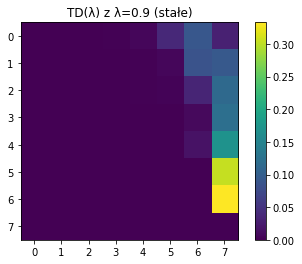

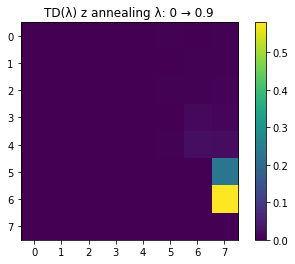

MSE do DP: λ stałe = 0.00390385
MSE do DP: annealing = 0.00354868


In [31]:
def td_lambda_prediction_variable_lambda(
    env,
    policy,
    nS: int,
    gamma: float = 0.99,
    alpha: float = 0.1,
    lam_fn=None,              # lam_fn(ep, t, s) -> λ_t
    episodes: int = 5_000,
    max_steps: int = 10_000,
    trace_mode: str = "accumulating",
):
    """
    TD(λ) prediction z eligibility traces, ale λ może zależeć od (ep, t, s).
    To celowo prosta wersja "do nauki intuicji", nie 'state-of-the-art'.
    """
    if lam_fn is None:
        lam_fn = lambda ep, t, s: 0.9

    V = np.zeros(nS, dtype=np.float64)

    for ep in range(episodes):
        e = np.zeros(nS, dtype=np.float64)
        s, _ = env.reset()
        s = int(s)

        for t in range(max_steps):
            lam = float(lam_fn(ep, t, s))
            lam = max(0.0, min(1.0, lam))  # clamp

            a = int(policy(s))
            sp, r, terminated, truncated, _ = env.step(a)
            sp = int(sp)
            done = bool(terminated or truncated)

            bootstrap = 0.0 if done else gamma * V[sp]
            delta = float(r) + bootstrap - V[s]

            # traces
            e *= gamma * lam
            if trace_mode == "replacing":
                e[s] = 1.0
            else:
                e[s] += 1.0

            # update
            V += alpha * delta * e

            s = sp
            if done:
                break

    return V

# --- Przykładowe schedule λ ---
EP = 5_000
ALPHA = 0.1
LAM_MAX = 0.9

lam_const = lambda ep, t, s: 0.9

# "annealing": przez pierwsze 40% epizodów rośniemy od 0 do LAM_MAX
def lam_ramp_up(ep, t, s, frac=0.4, lam_max=LAM_MAX):
    x = min(1.0, ep / max(1, int(frac * EP)))
    return lam_max * x

# (opcjonalnie) "ramp-down": odwrotnie
def lam_ramp_down(ep, t, s, frac=0.4, lam_max=LAM_MAX):
    x = min(1.0, ep / max(1, int(frac * EP)))
    return lam_max * (1.0 - x)

# --- Uruchomienia ---
V_const = td_lambda_prediction_variable_lambda(env, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=ALPHA,
                                               lam_fn=lam_const, episodes=EP, max_steps=10_000)

V_ramp  = td_lambda_prediction_variable_lambda(env, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=ALPHA,
                                               lam_fn=lam_ramp_up, episodes=EP, max_steps=10_000)

plot_value_heatmap(V_const, spec.shape, title="TD(λ) z λ=0.9 (stałe)")
plot_value_heatmap(V_ramp,  spec.shape, title="TD(λ) z annealing λ: 0 → 0.9")

# Jeśli mamy DP baseline, to policzmy MSE
if "V_dp" in globals() and V_dp is not None:
    mse_const = float(np.mean((V_const - V_dp)**2))
    mse_ramp  = float(np.mean((V_ramp  - V_dp)**2))
    print(f"MSE do DP: λ stałe = {mse_const:.6g}")
    print(f"MSE do DP: annealing = {mse_ramp:.6g}")
else:
    print("Brak V_dp: porównuj jakościowo mapy i stabilność (albo dodaj DP baseline).")


## Ćwiczenia (na zajęcia)

1) **Znajdź dobre $\lambda$**  
   - TODO: przeszukaj $\lambda \in \{0.0, 0.1, \dots, 1.0\}$ i znajdź minimum MSE (dla ustalonego `ALPHA` i `EP`).  
   - Pytanie: czy najlepsze $\lambda$ jest bliżej 0 czy 1?

2) **Trade-off bias–variance**  
   - Zwiększ `EP` (więcej danych) i zobacz, czy najlepsze $\lambda$ przesuwa się w stronę 1 (bardziej MC).  
   - Zmniejsz `EP` (mniej danych) i zobacz, czy najlepsze $\lambda$ przesuwa się w stronę 0 (bardziej TD).

3) **Dyskusja**  
   Czemu w praktyce TD(λ) bywa lepsze niż czyste TD(0) lub czyste MC?

4) **Mini‑zadanie (dla chętnych)**  
   - TODO: zamiast eligibility traces „accumulating” (`e[s] += 1`) spróbuj „replacing traces” (`e[s] = 1`).  
   - Czy to coś zmienia?
   
5) **Zabawa bonusem 7)** 
    - Można pobawić się bonusem i zależnością od lambda. Można spróbować zastsować ten kod dla bardziej złożonego środowiska